In [1]:
# Kristen Bystrom
# Set up Environment

In [2]:
#import sys
!pip install wordcloud --user
!pip install --user normalization
!pip install --user textblob

In [3]:
import io
import pandas as pd
import numpy as np
import glob
import re
import nltk
import sklearn
from sklearn.model_selection import train_test_split 
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
import matplotlib.pyplot as plt
from subprocess import check_output
from nltk.corpus import sentiwordnet as swn
import wordcloud
from wordcloud import WordCloud
from textblob import TextBlob
import csv
import operator

In [4]:
#Check file structure by reading in first file
#Must use utf 16 encoding
file = io.open('./sample_data/82.txt','r', encoding = 'utf-16-le')
content = file.read()
print(content)

﻿[Agent]Norman - Comm100: Hello Steph, this is Norman with Comm100! How may I help you today?
[Visitor]Steph: Hello, my company uses comm100 for our business in customer service. 
[Visitor]Steph: I am the supervisor, and I am the one who sets up the canned messages on live chat 
[Visitor]Steph: I set up shortcuts for certain messages. 
[Visitor]Steph: I am trying to enter them using "#[shortcut]" and it is not working. 
[Visitor]Steph: Can you help me?
[Agent]Norman - Comm100: Sure I can assist you with that
[Agent]Norman - Comm100: Are you getting any errors?
[Visitor]Steph: no.. it just sends the shortcut and the # to the customer. 
[Visitor]Steph: the canned message does not appear though. 
[Visitor]Steph: Is there something I need to do to activate it?
[Agent]Norman - Comm100: Have you tried our guide on canned messages?
[Visitor]Steph: I am actually on the page and it shows that the page cannot be found. 
[Visitor]Steph: Can you provide me with the link ?
[Visitor]comm100.PNG: The

In [5]:
#Read in Data, one conversation per line and store as a pandas data frame
files = glob.glob('sample_data/*')
conversations = pd.DataFrame(columns = ["ConversationID", "RawConversation"])
for i in range(len(files)):
    file = io.open((files[i]),'r', encoding = 'utf-16-le')
    content = file.read()
    df2 = pd.DataFrame([[files[i], str(content)]], columns = ["ConversationID", "RawConversation"])
    conversations = conversations.append(df2)

conversations.set_index("ConversationID", inplace = True)
conversations.head()

,RawConversation
ConversationID,
sample_data/801.txt,﻿[Agent]Johnny - Comm100 (Training): Dear Merv...
sample_data/473.txt,"﻿[Agent]Norman - Comm100: Hello Leo, this is N..."
sample_data/305.txt,"﻿[Agent]Terry - Comm100: Hi Anna, this is Terr..."
sample_data/9.txt,"﻿[Agent]Norman - Comm100: Hello Gurmeet Singh,..."
sample_data/764.txt,﻿[Visitor]AYAZ: ı cant change my name when ı t...


In [6]:
# remove timestamps from data
# we will need this when we separate the messages by opening hard brackets
re1='(\\[)'	# Any Single Character 1
re2='((?:[0]?[1-9]|[1][012])[-:\\/.](?:(?:[0-2]?\\d{1})|(?:[3][01]{1}))[-:\\/.](?:(?:\\d{1}\\d{1})))(?![\\d])'	# MMDDYY 1
re3='(\\])'	# Any Single Character 2
re4='.*?'	# Non-greedy match on filler
re5='(:)'	# Any Single Character 3

regex_pat = re.compile(re1+re2+re3+re4+re5,re.IGNORECASE|re.DOTALL)

conversations.RawConversation = conversations.RawConversation.str.replace(regex_pat, '')
conversations.head()

,RawConversation
ConversationID,
sample_data/801.txt,﻿[Agent]Johnny - Comm100 (Training): Dear Merv...
sample_data/473.txt,"﻿[Agent]Norman - Comm100: Hello Leo, this is N..."
sample_data/305.txt,"﻿[Agent]Terry - Comm100: Hi Anna, this is Terr..."
sample_data/9.txt,"﻿[Agent]Norman - Comm100: Hello Gurmeet Singh,..."
sample_data/764.txt,﻿[Visitor]AYAZ: ı cant change my name when ı t...


In [7]:
#Expand raw text file to one message per column
wide_df = conversations['RawConversation'].apply(lambda x: pd.Series(x.split('\n[')))
wide_df.reset_index(level=0, inplace=True)
wide_df.head()

,ConversationID,0,1,2,3,4,5,6,7,8,...,122,123,124,125,126,127,128,129,130,131
0,sample_data/801.txt,﻿[Agent]Johnny - Comm100 (Training): Dear Merv...,Visitor]Merve: hi johnny,Visitor]Merve: how can i use comm100 on iphone?,Visitor]Merve: I downloaded comm100 my phone,Visitor]Merve: but couldnt logging,Visitor]Merve: receive a warning '' email or p...,Visitor]Merve: But its true,Agent]Johnny - Comm100 (Training): Hi,Agent]Johnny - Comm100 (Training): Apologize f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sample_data/473.txt,"﻿[Agent]Norman - Comm100: Hello Leo, this is N...",Visitor]Leo: Norman my apologies I am leaving ...,Visitor]Leo: Is it possible for you to go to m...,Visitor]Leo: http://www1.toronto.ca/wps/portal...,"Visitor]Leo: open a chat, put test on the last...",Visitor]Leo: Are you there>?,Agent]Norman - Comm100: i am there,Visitor]Leo: yes but what I wanted you to see ...,"Visitor]Leo: send me another one, sorry",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sample_data/305.txt,"﻿[Agent]Terry - Comm100: Hi Anna, this is Terr...",Visitor]: The visitor has left the chat.\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sample_data/9.txt,"﻿[Agent]Norman - Comm100: Hello Gurmeet Singh,...",Visitor]Gurmeet Singh: Girls\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sample_data/764.txt,﻿[Visitor]AYAZ: ı cant change my name when ı t...,Visitor]AYAZ: What can ı do ?,"Agent]Brian - Comm100: Hello AYAZ, this is Bri...",Visitor]AYAZ: I cant change my name,Visitor]AYAZ: when ı try to change it is same ...,Visitor]AYAZ: this page is opne ?=,Visitor]AYAZ: what can ı do ?,Agent]Brian - Comm100: Have you cleared the ca...,Visitor]AYAZ: yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Convert from wide to long
long_df=pd.melt(frame = wide_df,id_vars=['ConversationID'], value_vars = list(range(1, 132)), var_name='MessageID', value_name='Message')
long_df.head()

,ConversationID,MessageID,Message
0,sample_data/801.txt,1,Visitor]Merve: hi johnny
1,sample_data/473.txt,1,Visitor]Leo: Norman my apologies I am leaving ...
2,sample_data/305.txt,1,Visitor]: The visitor has left the chat.\n
3,sample_data/9.txt,1,Visitor]Gurmeet Singh: Girls\n
4,sample_data/764.txt,1,Visitor]AYAZ: What can ı do ?


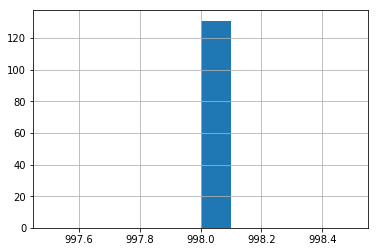

In [9]:
long_df.groupby(long_df.MessageID).MessageID.count().hist()

In [10]:
# delete rows where the message is NaN
long_df = long_df[long_df.Message.str.contains("NaN") == False]
long_df = long_df[long_df.Message.str.contains("NA") == False]
long_df.head()


,ConversationID,MessageID,Message
0,sample_data/801.txt,1,Visitor]Merve: hi johnny
1,sample_data/473.txt,1,Visitor]Leo: Norman my apologies I am leaving ...
2,sample_data/305.txt,1,Visitor]: The visitor has left the chat.\n
3,sample_data/9.txt,1,Visitor]Gurmeet Singh: Girls\n
4,sample_data/764.txt,1,Visitor]AYAZ: What can ı do ?


In [11]:
#Check that removing NaN worked
long_df.isnull().values.any()

False

In [12]:
# Detect who is speaking
long_df.loc[long_df['Message'].str.contains('Agent'), 'Speaker'] = 'Agent'
long_df.loc[long_df['Message'].str.contains('Visitor'), 'Speaker'] = 'Visitor'

long_df.head()

,ConversationID,MessageID,Message,Speaker
0,sample_data/801.txt,1,Visitor]Merve: hi johnny,Visitor
1,sample_data/473.txt,1,Visitor]Leo: Norman my apologies I am leaving ...,Visitor
2,sample_data/305.txt,1,Visitor]: The visitor has left the chat.\n,Visitor
3,sample_data/9.txt,1,Visitor]Gurmeet Singh: Girls\n,Visitor
4,sample_data/764.txt,1,Visitor]AYAZ: What can ı do ?,Visitor


In [13]:
long_df.Speaker.isnull().values.any()
long_df.loc[long_df.Speaker.isnull()]

,ConversationID,MessageID,Message,Speaker


In [14]:
# Clean up message cell
final_df = long_df
final_df.Message = final_df.Message.str.split(':').apply(lambda x: x[1:])
final_df.Message = final_df.Message.str[0]
final_df.Message = final_df.Message.str.replace("\n", "")
final_df.head()

,ConversationID,MessageID,Message,Speaker
0,sample_data/801.txt,1,hi johnny,Visitor
1,sample_data/473.txt,1,Norman my apologies I am leaving for a week a...,Visitor
2,sample_data/305.txt,1,The visitor has left the chat.,Visitor
3,sample_data/9.txt,1,Girls,Visitor
4,sample_data/764.txt,1,What can ı do ?,Visitor


In [15]:
# Get some metrics for the coment
final_df['numWords'] = final_df.Message.str.count(" ") + 1
final_df['numChar'] = final_df.Message.str.len()
final_df['WordsPerChar'] = final_df.numWords / final_df.numChar
final_df['UpperPerChar'] = (final_df.Message.str.replace('[^A-Z]', '').str.len())/final_df['numChar']
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000
1,sample_data/473.txt,1,Norman my apologies I am leaving for a week a...,Visitor,17,77,0.220779,0.038961
2,sample_data/305.txt,1,The visitor has left the chat.,Visitor,7,31,0.225806,0.032258
3,sample_data/9.txt,1,Girls,Visitor,2,6,0.333333,0.166667
4,sample_data/764.txt,1,What can ı do ?,Visitor,6,16,0.375000,0.062500


In [16]:
final_df.Message.isnull().values.any()

False

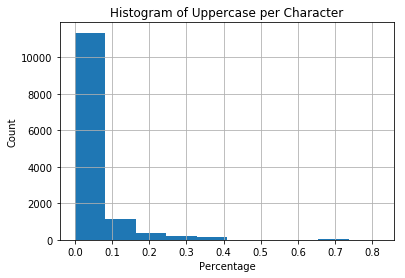

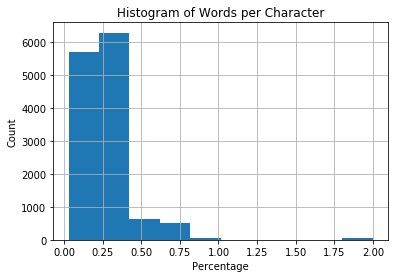

In [17]:
#Histogram of Percentage Uppercase
final_df.UpperPerChar.hist()
plt.xlabel('Percentage')
plt.ylabel('Count')
plt.title('Histogram of Uppercase per Character')
plt.show()

#Histogram of words per char
final_df.WordsPerChar.hist()
plt.xlabel('Percentage')
plt.ylabel('Count')
plt.title('Histogram of Words per Character')
plt.show()

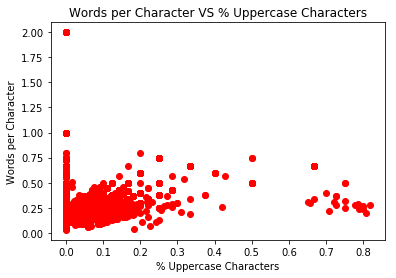

In [18]:
#Check if the metrics above are correlated
plt.plot(final_df.UpperPerChar, final_df.WordsPerChar, 'ro')
plt.xlabel('% Uppercase Characters')
plt.ylabel('Words per Character')
plt.title('Words per Character VS % Uppercase Characters')
plt.show()

In [19]:
#creating a list of trigger words for questions #Triggered 
final_df.Message = final_df.Message.str.lower()
Qwords=['why', 'how', 'when', 'what', 'where', 'can i', 'how does', '\?', 'how much', 'which of', 'which one', 'whose', 'may i'] 
pattern = '|'.join(Qwords)
pattern


'why|how|when|what|where|can i|how does|\\?|how much|which of|which one|whose|may i'

In [20]:
# To detect if someone is asking a question 

final_df.loc[final_df['Message'].str.contains(pattern) ,'Question'] =1
final_df.loc[final_df['Message'].str.contains(pattern)== False ,'Question'] =0
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar,Question
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000,0.0
1,sample_data/473.txt,1,norman my apologies i am leaving for a week a...,Visitor,17,77,0.220779,0.038961,0.0
2,sample_data/305.txt,1,the visitor has left the chat.,Visitor,7,31,0.225806,0.032258,0.0
3,sample_data/9.txt,1,girls,Visitor,2,6,0.333333,0.166667,0.0
4,sample_data/764.txt,1,what can ı do ?,Visitor,6,16,0.375000,0.062500,1.0


# NLTK & Sentiment

In [21]:
# Use the textblob package to get polarity (a scale version of sentiment)
final_df['Polarity'] = final_df.Message.apply(lambda x: TextBlob(x).sentiment.polarity)
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar,Question,Polarity
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000,0.0,0.0
1,sample_data/473.txt,1,norman my apologies i am leaving for a week a...,Visitor,17,77,0.220779,0.038961,0.0,0.0
2,sample_data/305.txt,1,the visitor has left the chat.,Visitor,7,31,0.225806,0.032258,0.0,0.0
3,sample_data/9.txt,1,girls,Visitor,2,6,0.333333,0.166667,0.0,0.0
4,sample_data/764.txt,1,what can ı do ?,Visitor,6,16,0.375000,0.062500,1.0,0.0


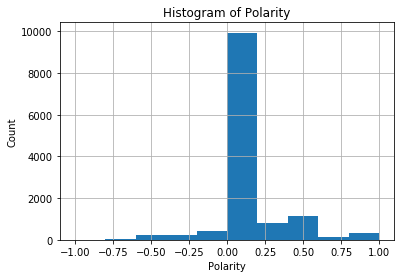

In [22]:
#Histogram of polarity
final_df.Polarity.hist()
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

In [23]:
#Check Polarity
final_df.Message[final_df.Polarity > .99].head()

433                       which coaching is best best iit
641      hi, i'm installing the code for our company a...
1066     it will be in your best interest to talk to o...
1236     hi michael, i can have one of my sales team m...
2199       what is the best size to use for email flyers 
Name: Message, dtype: object

In [24]:
#Check Polarity
final_df.Message[final_df.Polarity > .8].head()

433                       which coaching is best best iit
641      hi, i'm installing the code for our company a...
971                                   good morning brian!
1066     it will be in your best interest to talk to o...
1236     hi michael, i can have one of my sales team m...
Name: Message, dtype: object

In [25]:
# Import stopwords
nltk.download('stopwords')
from  nltk.corpus  import stopwords
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksbystrom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
stop = stopwords.words('english')

In [27]:
def clean_message(message):
    no_punc = re.sub('[' + punctuation + ']',' ',message)
    clean_message = [word.lower() for word in no_punc.split() if word.lower() not in stop]
    return clean_message

In [28]:
final_df['clean'] = final_df.Message.apply(lambda x: clean_message(x))
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar,Question,Polarity,clean
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000,0.0,0.0,"[hi, johnny]"
1,sample_data/473.txt,1,norman my apologies i am leaving for a week a...,Visitor,17,77,0.220779,0.038961,0.0,0.0,"[norman, apologies, leaving, week, need, solve..."
2,sample_data/305.txt,1,the visitor has left the chat.,Visitor,7,31,0.225806,0.032258,0.0,0.0,"[visitor, left, chat]"
3,sample_data/9.txt,1,girls,Visitor,2,6,0.333333,0.166667,0.0,0.0,[girls]
4,sample_data/764.txt,1,what can ı do ?,Visitor,6,16,0.375000,0.062500,1.0,0.0,[ı]


In [29]:
#delete non-English language
final_df = final_df[final_df.Message.str.contains(r'[^\x00-\x7F]+') == False]
final_df = final_df.reset_index(level=0, drop = True)
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar,Question,Polarity,clean
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000,0.0,0.0,"[hi, johnny]"
1,sample_data/473.txt,1,norman my apologies i am leaving for a week a...,Visitor,17,77,0.220779,0.038961,0.0,0.0,"[norman, apologies, leaving, week, need, solve..."
2,sample_data/305.txt,1,the visitor has left the chat.,Visitor,7,31,0.225806,0.032258,0.0,0.0,"[visitor, left, chat]"
3,sample_data/9.txt,1,girls,Visitor,2,6,0.333333,0.166667,0.0,0.0,[girls]
4,sample_data/25.txt,1,hi,Visitor,2,3,0.666667,0.000000,0.0,0.0,[hi]


In [30]:
# Find list of unique words in the data frame
results = set()
final_df.clean.apply(results.update)
print(results)

{'disconnect', 'dropdown', 'operate', 'shadow', 'rtol', 'ensure', 'failed', 'pages', 'electroacustics', 'wharton', 'rush', 'use', 'notification', 'eight', 'serious', 'saved', 'kiss', 'upload', 'shadmi', 'indian', 'alivesupport', '29x3', 'followed', 'summit', 'salesforce', 'agency', 'caused', '1055', 'safetyinsurance', '706', 'build', 'gmails', '420', 'cn', 'francisco', 'recommend', 'link', 'shousha', 'bvv', 'cobrando', 'chinese', 'mac', 'theres', 'mi', 't557820', 'overdue', 'selling', 'ago', '15', 'manish', '96', 'bit', 'phishing', 'permite', 'smita', 'addison', 'engineers', 'comparing', 'iicvisa', 'atleast', 'screenshot', 'tenha', 'excel', 'changing', 'jonathan', 'availabe', 'picking', 'buggy', 'b', 'host', 'probably', 'imperfect', 'homeopath', '71765', 'move', 'pharalk', 'ringel', 'conacts', 'burcu', 'virta', 'stamp', 'incoming', 'going', 'este', 'thing', 'manual', 'premium', 'policies', 'chage', 'data', 'kenta', 'ra', 'membership', '100', 'chargeback', 'descargo', '5starslimo', 'lin

In [31]:
from collections import Counter
top_200 = [item[0] for item in Counter(results).most_common(200)]
print(top_200[0:10])

['disconnect', 'dropdown', 'operate', 'shadow', 'rtol', 'ensure', 'failed', 'pages', 'electroacustics', 'wharton']


In [32]:
def  word2vector (message):
    vec = np.zeros(200)
    for i in range(0,200):
        if top_200[i] in message:
            vec[i] = 1
        else:
            vec[i] = 0
    return vec

In [33]:
final_df['buckets'] = (final_df.Message.apply(lambda x: word2vector(x)))

In [34]:
final_df[top_200] = pd.DataFrame(final_df.buckets.values.tolist(), index= final_df.index)
final_df.head()

,ConversationID,MessageID,Message,Speaker,numWords,numChar,WordsPerChar,UpperPerChar,Question,Polarity,...,receiving,unfortunately,duration,129499,120,referrring,replace,installaion,samuel,ending
0,sample_data/801.txt,1,hi johnny,Visitor,3,10,0.300000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,sample_data/473.txt,1,norman my apologies i am leaving for a week a...,Visitor,17,77,0.220779,0.038961,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,sample_data/305.txt,1,the visitor has left the chat.,Visitor,7,31,0.225806,0.032258,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sample_data/9.txt,1,girls,Visitor,2,6,0.333333,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,sample_data/25.txt,1,hi,Visitor,2,3,0.666667,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
final_df.to_csv("final_df.csv")